# Loading modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, lognorm
from scipy.stats import gaussian_kde
from matplotlib.colors import LogNorm
from scipy.constants import G
from matplotlib import cm
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import pandas as pd

# Loading data

In [7]:
hot_jupiters = pd.read_csv("sample_planets.csv",index_col=0)

# Loading functions

In [277]:
nearby_comp_hj_list = [
    "WASP-84","TOI-2000","TOI-1130","TOI-1408","WASP-47","WASP-132","TOI-2202"
]

nearby_comp_hj = hot_jupiters[hot_jupiters["hostname_omit_binary_signature"].isin(nearby_comp_hj_list)]

def get_parameter_description(column_name):
    descriptions = {
        "pl_name": ("Planet name", r"Name", ""),
        "hostname": ("Host star name", r"\text{Host}", ""),
        "hostname_omit_binary_signature": ("Host star name (binary removed)", r"\text{Host}_{\text{clean}}", ""),
        "sy_pnum": ("Number of planets", r"$N_{\mathrm{pl}}$", ""),
        "sy_vmag": ("V-band magnitude", r"$V$", "mag"),
        "circularization_timescale": ("Circularization timescale", r"$\tau_\mathrm{cir}$", "Gyr"),
        "st_age": ("Stellar age", r"$\tau_\mathrm{age}$", "Gyr"),
        "tau_over_age": ("Circularization / age", r"$\tau_\mathrm{cir}/\tau_\mathrm{age}$", ""),
        "pl_orbeccen": ("Eccentricity", r"$e$", ""),
        "pl_orbeccenlim": ("Eccentricity upper limit flag", r"$\text{uplim}$", "bool"),
        "st_mass": ("Stellar mass", r"$M_\star$", r"$M_\odot$"),
        "st_teff": ("Effective temperature", r"$T_\mathrm{eff}$", "K"),
        "st_rad": ("Stellar radius", r"$R_\star$", r"R_\odot"),
        "st_met": ("Metallicity", r"[{$\rm Fe}/{\rm H$}]", "dex"),
        "pl_mass_combinej": ("Planet mass or msini", r"$M_p\ \mathrm{or}\ M_p\sin i$", r"M_J"),
        "pl_massj": ("Planet mass", r"$M_p$", r"M_J"),
        "pl_radj": ("Planet radius", r"$R_p$", r"R_J"),
        "pl_orbper": ("Orbital period", r"$P$", "days"),
        "pl_orbsmax": ("Semi-major axis", r"$a$", "AU"),
        "pl_ratdor": ("Scaled semi-major axis", r"$a/R_\star$", ""),
        "pl_dens": ("Planet density", r"$\rho_p$", r"\mathrm{g/cm}^3"),
        "lambda": ("Projected obliquity", r"$\lambda$", "deg"),
        "mass_ratio": ("Mass ratio", r"$q = M_p / M_\star$", ""),
    }

    return descriptions.get(column_name, ("Unknown parameter", "?", ""))

def period_to_semimajor_axis(period_days, stellar_mass_solar):
    """
    Convert orbital period to semi-major axis using Kepler's Third Law.

    Parameters:
    - period_days: Orbital period in days
    - stellar_mass_solar: Stellar mass in solar masses

    Returns:
    - Semi-major axis in AU
    """
    G = 6.67430e-11  # gravitational constant in m^3 kg^-1 s^-2
    M_sun = 1.98847e30  # mass of the sun in kg
    AU = 1.495978707e11  # 1 AU in meters

    period_seconds = period_days * 86400  # convert days to seconds
    M_star_kg = stellar_mass_solar * M_sun

    a_meters = (G * M_star_kg * period_seconds**2 / (4 * np.pi**2))**(1/3)
    a_au = a_meters / AU

    return a_au

typical_hj_filter = hot_jupiters["tau_over_age"] < 10
#typical_hj_filter = hot_jupiters["pl_orbsmax"] > 0.02

typical_hj = hot_jupiters[typical_hj_filter]

period_range = np.linspace(0.7,365,100)

typical_smax = period_to_semimajor_axis(period_range,np.nanmedian(typical_hj["st_mass"]))

typical_age = np.nanmedian(typical_hj["st_age"])

typical_tau = 1.6 * (4.92*10**5/10**6) * \
    (np.nanmedian(typical_hj["pl_mass_combinej"])) * \
    np.nanmedian(typical_hj["st_mass"])**-1.5 * \
    np.nanmedian(typical_hj["pl_radj"])**-5 * \
    ((typical_smax)/0.05)**6.5

typical_tau2 = 1.6 * (4.92*10**5/10**6) * \
    (np.nanmedian(typical_hj["pl_mass_combinej"])) * \
    np.nanmedian(typical_hj["st_mass"])**-1.5 * \
    np.nanmedian(typical_hj["pl_radj"])**-5 * \
    ((np.linspace(0,1,100))/0.05)**6.5

typical_tau_over_age = typical_tau/typical_age
typical_tau_over_age2 = typical_tau2/typical_age

mass_range = np.linspace(0,20,100)

typical_tau_mass = 1.6 * (4.92*10**5/10**6) * \
    mass_range * \
    np.nanmedian(typical_hj["st_mass"])**-1.5 * \
    np.nanmedian(typical_hj["pl_radj"])**-5 * \
    ((np.nanmedian(typical_hj["pl_orbsmax"]))/0.05)**6.5

typical_tau_mass = 1.6 * (4.92*10**5/10**6) * \
    mass_range * \
    1**-1.5 * \
    1**-5 * \
    (0.04/0.05)**6.5

typical_tau_over_age_mass = typical_tau_mass/typical_age

jmass_s = 1047.348644  # Jupiter masses per solar mass

# Compute mass ratio
hot_jupiters["mass_ratio"] = hot_jupiters["pl_mass_combinej"] / (hot_jupiters["st_mass"] * jmass_s)

# First error term: planet mass error propagated through division
first_err_term1 = (1 / (hot_jupiters["st_mass"] * jmass_s)) * hot_jupiters["pl_massjerr1"]
first_err_term2 = (1 / (hot_jupiters["st_mass"] * jmass_s)) * hot_jupiters["pl_massjerr2"]

# Second error term: stellar mass error propagated through division
second_err_term1 = (
    hot_jupiters["pl_mass_combinej"] /
    (hot_jupiters["st_mass"]**2 * jmass_s)
) * hot_jupiters["st_masserr1"]

second_err_term2 = (
    hot_jupiters["pl_mass_combinej"] /
    (hot_jupiters["st_mass"]**2 * jmass_s)
) * hot_jupiters["st_masserr2"]

# Total asymmetric errors
hot_jupiters["mass_ratioerr1"] = np.sqrt(first_err_term1**2 + second_err_term1**2)
hot_jupiters["mass_ratioerr2"] = np.sqrt(first_err_term2**2 + second_err_term2**2)

'''
def plot_binned_subplots(x_var, x_err_var, y_vars, y_err_vars, masks, ylims):
    num_vars = len(y_vars)
    fig, axes = plt.subplots(num_vars * 2, 1, figsize=(8, 3 * num_vars), sharex=True, gridspec_kw={'height_ratios': [3, 1] * num_vars})
    
    if num_vars == 1:
        axes = [axes]  # Ensure axes is always iterable
        
    for index, (ax, ax_hist), y_var, y_err_var, mask, ylim in zip(range(num_vars), zip(axes[::2], axes[1::2]), y_vars, y_err_vars, masks, ylims):
        ax, ax_hist = ax, ax_hist
'''

def err_is_na(hot_jupiters_df, column_name):
    upper = hot_jupiters_df[f"{column_name}err1"].isna()
    lower = hot_jupiters_df[f"{column_name}err2"].isna()
    return upper | lower

    
def plot_binned_subplots(x_var, x_err_var, y_vars, y_err_vars, masks, ylims, 
                         show_hist=True, color_code=True, color_code_param="mass_ratio", 
                         scatter_color="cadetblue",nearby_comp=True,outpath=None):

    if show_hist==True and color_code!=True:
        print("color_code must be true when show_hist==True")
        sys.exit()

    num_vars = len(y_vars)
    
    # Build the height ratios: 3 for normal plot, 1 for histogram if needed
    height_ratios = []

    base_parameter = color_code_param
    
    fig = plt.figure(figsize=(10, 2 * num_vars + 2))
    # +1 row for top histogram, 2 columns: main + side hist
    num_rows = num_vars
    if show_hist:
        num_rows += 1

    gs = gridspec.GridSpec(num_rows + 1, 2, width_ratios=[5, 0.7], height_ratios=[0.5] + [1]*num_rows, hspace=0.0, wspace=0.0)

    # --- Top histogram (row 0, spanning both columns) ---
    if show_hist:
        ax_top_hist = fig.add_subplot(gs[0, 0])
    else:
        ax_top_hist = None
        
    axes = []
    axes_hist = []

    for i, (y_var, y_err_var, mask, ylim) in enumerate(zip(y_vars, y_err_vars, masks, ylims)):
        row = i + 1  # offset by 1 because of top hist

        # Main plot
        if show_hist and ax_top_hist is not None:
            ax = fig.add_subplot(gs[row, 0], sharex=ax_top_hist)
        else:
            ax = fig.add_subplot(gs[row, 0])

        # Side histogram
        if show_hist:
            ax_hist = fig.add_subplot(gs[row, 1])
            ax_hist2 = ax_hist.twinx()
        else:
            ax_hist = ax_hist2 = None

        masked_hot_jupiters = hot_jupiters[mask]
        innercomp = masked_hot_jupiters["pl_name"].isin(nearby_comp_hj["pl_name"])
        
        x = masked_hot_jupiters[x_var]
        x_err1 = masked_hot_jupiters[f"{x_err_var}1"]
        x_err2 = masked_hot_jupiters[f"{x_err_var}2"]
        y = masked_hot_jupiters[y_var]
        y_err1 = masked_hot_jupiters[f"{y_err_var}1"]
        y_err2 = masked_hot_jupiters[f"{y_err_var}2"]

        # Plot
        x_err_notna = (~x_err2.isna() & x_err1.isna()) | (~x_err2.isna() & ~x_err1.isna())
        x_below_elim = masked_hot_jupiters["pl_orbeccen"] < 0.1
        x_above_elim = (masked_hot_jupiters["pl_orbeccen"] >= 0.1) & (err_is_na(masked_hot_jupiters,"pl_orbeccen"))
        x_eccentric = (masked_hot_jupiters["pl_orbeccen"] >= 0.1)  &(~err_is_na(masked_hot_jupiters,"pl_orbeccen"))
        
        x_err_meaningful = ((masked_hot_jupiters[x_var] > 1) & 
                           ((masked_hot_jupiters[x_var] - x_err2) > 0.1))

        x_err_pl_massjerr_notna    = ~err_is_na(masked_hot_jupiters,"pl_massj")
        x_err_st_ageerr_notna      = ~(masked_hot_jupiters["st_age"]==13.8)
        x_err_pl_orbsmaxerr_notna  = ~err_is_na(masked_hot_jupiters,"pl_orbsmax")
        x_err_pl_radjerr_notna     = ~err_is_na(masked_hot_jupiters,"pl_radj")
        x_err_st_masserr_notna     = ~err_is_na(masked_hot_jupiters,"st_mass")
        x_err_pl_orbeccenerr_notna = ~err_is_na(masked_hot_jupiters,"pl_orbsmax")
        
        x_err_plot = x_err_meaningful & x_below_elim
        x_scatter_plot = x_err_pl_massjerr_notna & x_err_notna & x_below_elim

        x_tau_age_lolim_plot = x_err_pl_massjerr_notna & ~x_err_notna
        x_tau_age_lolim_mass_uplim_plot = ~x_err_pl_massjerr_notna & ~x_err_notna

        # Add density contour
        # First convert to log scale for x since we're using log scale for display
        x_log = np.log10(x[x_scatter_plot])
        y_data = y[x_scatter_plot]
        
        # Create a mask for valid data points (no NaN or inf values)
        valid_mask = np.isfinite(x_log) & np.isfinite(y_data)
        x_valid = x_log[valid_mask]
        y_valid = y_data[valid_mask]
            
        if len(x_valid) > 5:  # Need enough points for KDE
            
            # Create a 2D Gaussian KDE
            xy = np.vstack([x_valid, y_valid])
            kde = gaussian_kde(xy)

            # Create a grid for evaluating the KDE
            x_grid = np.linspace(-6, 9, 300)
            if y_var == "circularization_timescale":
                # For log-scaled y-axis
                y_grid = np.linspace(np.log10(ylim[0]), np.log10(ylim[1]), 100)
            else:
                y_grid = np.linspace(ylim[0], ylim[1], 100)
            
            X, Y = np.meshgrid(x_grid, y_grid)
            positions = np.vstack([X.ravel(), Y.ravel()])
            Z = kde(positions)
            Z = Z.reshape(X.shape)
        
            # Plot the contour
            if y_var == base_parameter:
                pass
                # Convert Y grid back from log space for plotting
                #contour = ax.contourf(10**X, Y, Z, cmap="Greys", alpha=1, levels=10,zorder=0)
                contour = ax.contour(10**X, Y, Z, colors="gray",linestyles='dashed', alpha=0.5, levels=10,zorder=1)
            else:
                contour = ax.contourf(10**X, Y, Z, cmap="Greys", alpha=1, levels=10,zorder=0)
                #contour = ax.contourf(10**X, Y, Z, cmap='Greys', alpha=1, levels=10,zorder=0)

        cmap = cm.YlGn
        #colors = ["white", "powderblue", "cadetblue", "darkcyan"]  # adjust to taste
        
        # Create discrete colormap
        #cmap = ListedColormap(colors, name='custom_blue4')
        if color_code == True:
            valid = masked_hot_jupiters[color_code_param].dropna()
    
            # Compute quartile edges (0%, 25%, 50%, 75%, 100%)
            q0, q25, q50, q75, q90, q100 = np.percentile(valid, [0, 25, 50, 75, 90, 100])
            
            group1 = (masked_hot_jupiters[color_code_param] >= q75)        
            group2 = (masked_hot_jupiters[color_code_param] >= q50) & (masked_hot_jupiters[color_code_param] < q75)
            group3 = (masked_hot_jupiters[color_code_param] >= q25) & (masked_hot_jupiters[color_code_param] < q50)
            group4 = (masked_hot_jupiters[color_code_param] < q25)
            
            hist_plot1 = x[group1]
            hist_plot2 = x[group2]
            hist_plot3 = x[group3]
            hist_plot4 = x[group4]

            quantiles = [q0, q25, q50, q75, q100]  # ascending order
            norm = mcolors.BoundaryNorm(boundaries=quantiles, ncolors=cmap.N, extend='neither')
            
            legend_colors = [cmap(norm((q1 + q2) / 2)) for q1, q2 in zip(quantiles[:-1], quantiles[1:])]

            name, symbol, unit = get_parameter_description(color_code_param)
            labels = [
                f"0–25th    ({symbol} < {q25:5.2f} {unit})",
                f"25–50th   ({q25:5.2f} {unit} ≦ {symbol} < {q50:5.2f} {unit})",
                f"50–75th   ({q50:5.2f} {unit} ≦ {symbol} < {q75:5.2f} {unit})",
                f"75–100th  ({symbol} ≧ {q75:5.2f} {unit})",
            ]
            legend_colors = [cmap(norm(q)) for q in quantiles]
            
            if i == 0:
                for label, color in zip(labels, legend_colors):
                    ax.scatter([], [], color=color, edgecolor="k",label=label)  # dummy invisible point

            if y_var == color_code_param:
                for quantile, mass in enumerate(quantiles):
                    if quantile == len(quantiles)-1:
                        break
                    color = cmap(norm(mass))
                    ax.fill_between([0,tau_age_plot_lim],y1=quantiles[quantile],y2=quantiles[quantile+1],color=color,alpha=0.9,zorder=0)

            # Scatter plot
            colors = cmap(norm(masked_hot_jupiters[color_code_param][x_scatter_plot]))
            colors_tau_age_lolim = cmap(norm(masked_hot_jupiters[color_code_param][x_tau_age_lolim_plot]))
            colors_innercomp = cmap(norm(masked_hot_jupiters[color_code_param][x_scatter_plot][innercomp]))
            colors_massjerrna = cmap(norm(masked_hot_jupiters[color_code_param][~x_err_pl_massjerr_notna][x_below_elim]))
            colors_mass_uplim = cmap(norm(masked_hot_jupiters[color_code_param][x_tau_age_lolim_mass_uplim_plot]))
            colors1 = cmap(norm(masked_hot_jupiters[color_code_param][x_above_elim]))
            colors2 = cmap(norm(masked_hot_jupiters[color_code_param][x_eccentric]))
        else:
            colors = scatter_color
            colors_tau_age_lolim = scatter_color
            colors_innercomp = scatter_color
            colors1 = scatter_color
            colors2 = scatter_color
            colors_massjerrna = scatter_color
            colors_mass_uplim = scatter_color

            labels = []

        if show_hist:
            # Create logarithmically-spaced bins
            logbins = np.logspace(np.log10(x[x_scatter_plot].min()), 
                                  np.log10(x[x_scatter_plot].max()), 
                                  32)
            ax_top_hist.hist(x,color="gray",bins=logbins,alpha=0.5)
    
            ax_hist_secondary = ax_top_hist.twinx()
    
            counts, bins, _ = ax_hist_secondary.hist([hist_plot4, hist_plot3, hist_plot2, hist_plot1],
                                       stacked=False,
                                       bins=logbins,
                                       edgecolor='black',  # Add this line to create borders
                                       color= [cmap(norm(mass)) for mass in quantiles[:-1]],
                                       #label=labels,
                                       alpha=0.9,
                                          )
            
            ax_top_hist.set_xscale('log')
            ax_top_hist.set_yticks([])
            ax_hist_secondary.set_yticks([])
            ax_top_hist.tick_params(labelbottom=False)
            for spine in ax_top_hist.spines.values():
                spine.set_visible(False)
            for spine in ax_hist_secondary.spines.values():
                spine.set_visible(False)
                
        x_err1_fix = np.array([0 if np.isnan(item) else item for item in x_err1[x_err_plot]])

        ax.errorbar(x[x_err_plot], y[x_err_plot], 
                    xerr=(x_err2[x_err_plot],x_err1_fix), 
                    yerr=(y_err2[x_err_plot],y_err1[x_err_plot]),
                    fmt='.', alpha=0.5,capsize=5, c="gray",zorder=0)

        y_err1_fix = np.array([0 if np.isnan(item) else np.abs(item) for item in y_err1[~x_err_plot]])
        y_err2_fix = np.array([0 if np.isnan(item) else np.abs(item) for item in y_err2[~x_err_plot]])
        if color_code == True and color_code_param == "mass_ratio":
            colors_massjerrna = "gray"
            colors_mass_uplim = "gray"
        ax.scatter(x[~x_err_pl_massjerr_notna][x_below_elim], y[~x_err_pl_massjerr_notna][x_below_elim], c=colors_massjerrna, edgecolor="k", zorder=1)
        #ax.scatter(x[x_tau_age_lolim_mass_uplim_plot], y[x_tau_age_lolim_mass_uplim_plot], alpha=1, c=colors_mass_uplim, edgecolor="k",marker=">", zorder=1)        
        ax.errorbar(x[~x_err_plot], y[~x_err_plot], yerr=(y_err2_fix,y_err1_fix), fmt='.', alpha=0.5,capsize=5, c="gray",zorder=0)
        ax.scatter(x[x_above_elim], y[x_above_elim], alpha=1, c=colors1, edgecolor="k",zorder=1)
        ax.scatter(x[x_eccentric], y[x_eccentric], alpha=1, c=colors2, edgecolor="k", zorder=1)

        ax.scatter(x[x_scatter_plot], y[x_scatter_plot], alpha=1, c=colors, edgecolor="k", zorder=1)

        ax.scatter(x[x_tau_age_lolim_plot], y[x_tau_age_lolim_plot], alpha=1, c=colors_tau_age_lolim, edgecolor="k",marker=">", zorder=1)
        ax.scatter(x[x_scatter_plot][innercomp], y[x_scatter_plot][innercomp], alpha=1, c=colors_innercomp, edgecolor="k",zorder=1)

        if nearby_comp == True:
            ax.scatter(x[x_scatter_plot][innercomp], y[x_scatter_plot][innercomp], alpha=1, c=colors_innercomp, edgecolor="k", s=8,zorder=1)        

        period_largerthansix = masked_hot_jupiters["pl_orbper"] > 6
        
        if y_var == "pl_orbper":
            ax.plot(typical_tau_over_age,period_range,color="gray",linestyle="dashed",zorder=0)
            ax.plot(np.linspace(0,tau_age_plot_lim,2),np.full(2,10),color="gray",linestyle="dashed",zorder=0)
        if y_var == "pl_orbsmax":
            ax.plot(typical_tau_over_age2,np.linspace(0,1,100),color="gray",linestyle="dashed",zorder=0)
            ax.plot(np.linspace(0,tau_age_plot_lim,2),np.full(2,0.1),color="gray",linestyle="dashed",zorder=0)
        if y_var == "pl_mass_combinej":
            #ax.plot(typical_tau_over_age_mass,mass_range,color="gray",linestyle="dashed")
            pass

        ax.axvline(1, c="gray",zorder=0)
        if show_hist:
            hist_nbins = 9
            if y_var in ["pl_mass_combinej","mass_ratio","pl_orbper","st_age","pl_dens","pl_orbsmax"]:
                bins  = np.logspace(np.log10(y[x_scatter_plot].min()), 
                                    np.log10(y[x_scatter_plot].max()), 
                                    hist_nbins)
                bin_centers = np.sqrt(bins[:-1] * bins[1:])
                for ax_hists in [ax_hist,ax_hist2]:
                    ax_hists.set_yscale('log')
    
            else:
                bins = np.linspace(y[x_scatter_plot].min(),y[x_scatter_plot].max(),hist_nbins)
                bin_centers = 0.5 * (bins[:-1] + bins[1:])
                
            bin_heights = np.diff(bins)
    
            data1 = y[x_scatter_plot][x>=1]
            data2 = y[x_scatter_plot][x<1]
    
            data3 = y[(x_eccentric) | (x_above_elim)][x>=1]
            data4 = y[x_above_elim][x>=1]
    
            # Number of data points
            N1 = len(data1)
            N2 = len(data2)
    
            N3 = len(data3)
            N4 = len(data4)
    
            N_total = len(data1) + len(data3)
    
            # Compute weights so sum(weights) = 1
            weights1 = np.ones(N1) / N1
            weights2 = np.ones(N2) / N2
            weights3 = np.ones(N3) / N3
            weights4 = np.ones(N4) / N4
    
            hist1, _ = np.histogram(data1, bins=bins,weights=weights1)
            hist2, _ = np.histogram(data2, bins=bins,weights=weights2)
            hist3, _ = np.histogram(data3, bins=bins,weights=weights3)
            hist4, _ = np.histogram(data4, bins=bins,weights=weights4)
    
            ax_hist.barh(bin_centers, hist1, height=bin_heights, color="white",
                         edgecolor="k", alpha=1)
            
            ax_hist2.barh(bin_centers, -hist2, height=bin_heights, color="gray",
                          edgecolor="k", alpha=1)
    
            for ax_hists in [ax_hist,ax_hist2]:
                for spine in ax_hists.spines.values():
                    spine.set_visible(False)

        ax.yaxis.set_tick_params(labelleft=True)

        fontsize = 15
        if y_var == "pl_orbper":
            ax.set_yscale("log")
            ax.set_ylabel("Orbital Period\n(days)",fontsize=fontsize)
        if y_var == "pl_orbsmax":
            ax.set_yscale("log")
            ax.set_ylabel("Semi-major axis\n(AU)",fontsize=fontsize)
        if y_var == "pl_mass_combinej":
            ax.set_yscale("log")
            ax.set_ylabel("Planet Mass\n(Mj)",fontsize=fontsize)
        if y_var == "mass_ratio":
            ax.set_yscale("log")
            ax.set_ylabel("Mass ratio\n(Mp/M*)",fontsize=fontsize)
        if y_var == "pl_dens":
            ax.set_yscale("log")
            ax.set_ylabel("Planet \ndensity (g/cm^3)",fontsize=fontsize)
        if y_var == "st_age":
            ax.set_yscale("log")
            ax.set_ylabel("Stellar age (Gyr)",fontsize=fontsize)
        if y_var == "lambda":
            ax.set_ylabel("Projected \noblquity (deg)",fontsize=fontsize)     
        if y_var == "st_met":
            ax.set_ylabel("Stellar \nmetallicity (dex)",fontsize=fontsize)    
        if y_var == "pl_radj":
            ax.set_ylabel("Planet radius (Rj)",fontsize=fontsize)    

        tick_fontsize = 14
        ax.tick_params(axis='both', which='both', labelsize=tick_fontsize)
   
        ax.set_ylim(ylim[0],ylim[1])
        ax.set_xlim(0.000005, tau_age_plot_lim)

        if i < num_vars - 1:
            ax.tick_params(labelbottom=False)
        else:
            ax.set_xlabel(r"$\tau_\mathrm{cir}/\tau_\mathrm{age}$", fontsize=fontsize)
            ax.set_xscale("log")

        if show_hist:
            for ax_hists in [ax_hist,ax_hist2]:
                ax_hists.set_xticks([])
                ax_hists.set_yticks([])
                ax_hists.tick_params(axis='x', which='minor', bottom=False, top=False)
                ax_hists.tick_params(axis='y', which='minor', left=False, right=False)
    
                ax_hists.spines[['top', 'right','bottom','left']].set_visible(False)

        ax.spines['right'].set_visible(True)
        ax.yaxis.set_tick_params(right=True,        # Enable right-side ticks
                                 direction='in')    # Point ticks inward
        ax.tick_params(which='major', length=7, direction='in', right=True)
        ax.tick_params(which='minor', length=4, direction='in', right=True)
        ax.set_zorder(10)
        ax.patch.set_visible(False)  # To prevent overdraw if needed

        #ax_idx += 1
        axes.append(ax)
        if show_hist:
            axes_hist.append(ax_hist)
            axes_hist.append(ax_hist2)
    fig.tight_layout()
    fig.align_ylabels(axes)
    fig.subplots_adjust(hspace=0.0, wspace=0.0)
    plt.legend(frameon=False)
    plt.subplots_adjust(hspace=0)  # Remove gaps between subplots
    if outpath:
        plt.savefig(outpath,format="pdf", bbox_inches="tight")
    plt.show()
    return axes

# Recreating the general plot

You can recreate Figure 3 with the below cell. You can also change the variables and plotting masks/limits as you wish.

/tmp/ipykernel_1611509/2746062163.py:510: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False)


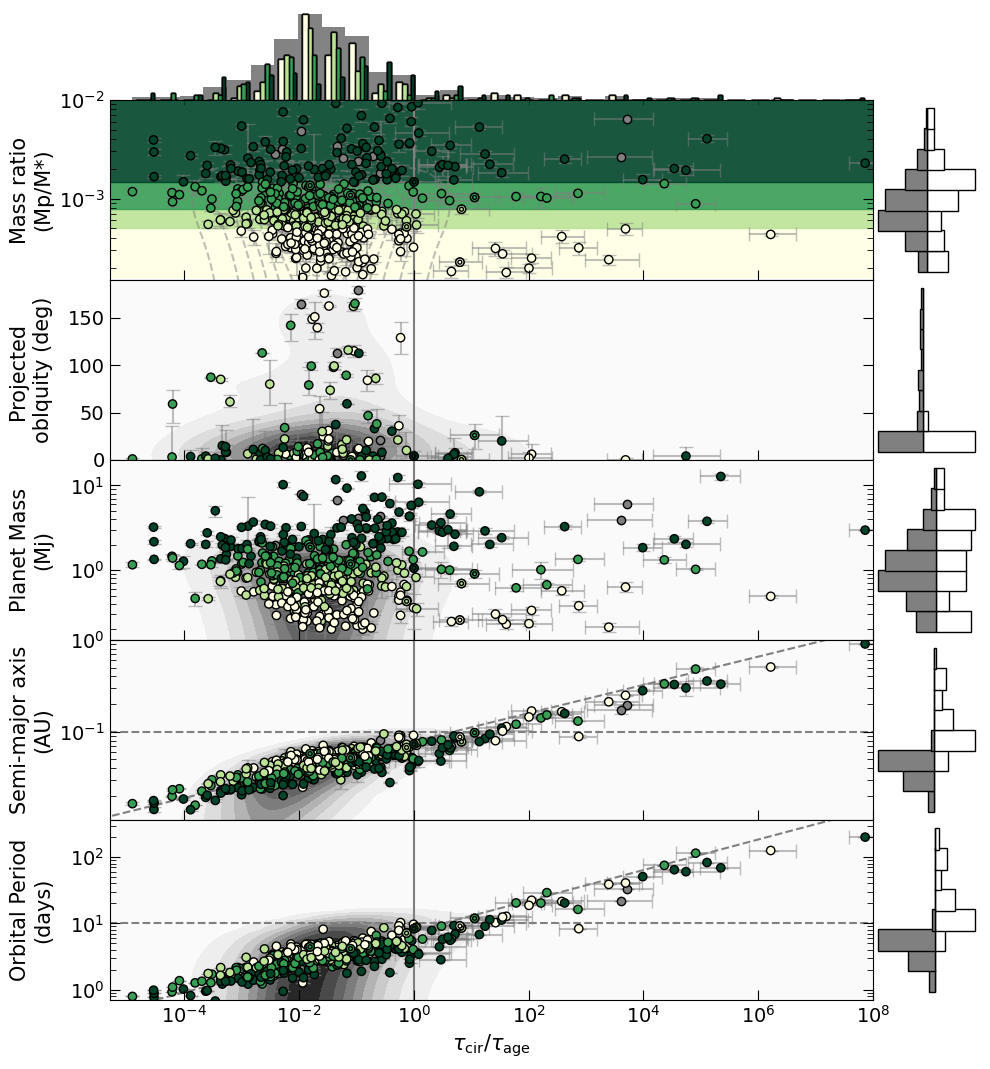

In [278]:
eccenlim = 0.1
tau_age_plot_lim = 1e8

y_vars = [
          "mass_ratio",
          "lambda",
          "pl_mass_combinej",
          "pl_orbsmax",
          "pl_orbper",
          #"st_met",
          #"st_age"
          #"circularization_timescale"
         ]  # Add more variables as needed

y_err_vars = [f"{var}err" for var in y_vars]

default_mask = hot_jupiters["pl_orbper"] > 0
default_mask &= ~hot_jupiters["tau_over_age"].isna()
default_mask &= hot_jupiters["tau_over_age"] < tau_age_plot_lim
default_mask &= hot_jupiters["tau_over_age"] > 0.0000
default_mask &=  ((hot_jupiters["pl_orbeccen"] <= eccenlim) | (hot_jupiters["tau_over_age"] <= 1))
    
masks = [
         default_mask, #& ((hot_jupiters["pl_orbeccen"] <= eccenlim) | (hot_jupiters["tau_over_age"] <= 1)), #& (hot_jupiters["pl_orbeccenlim"] == 1),
         default_mask & (hot_jupiters["lambda"]!=999),# & (hot_jupiters["pl_orbeccen"] < eccenlim),# & (hot_jupiters["pl_orbeccenlim"] == 1),
         default_mask,
         default_mask,#, & ((hot_jupiters["pl_orbeccen"] <= eccenlim) | (hot_jupiters["tau_over_age"] <= 1)),
         default_mask,
         #default_mask & ((hot_jupiters["st_met"] > -1) | (hot_jupiters["st_met"] > -1)),# &  ((hot_jupiters["pl_orbeccen"] <= eccenlim) | (hot_jupiters["tau_over_age"] <= 1)),
         #default_mask & (hot_jupiters["tau_over_age"]<100) & (hot_jupiters["pl_orbeccen"] < eccenlim),
        ]

ylims = [
        (1.5e-4,1e-2),
        (0,190),
        (0.15,20),
        (0.011,1),
        (0.7,365),
        #(-0.7,0.7),
        #(0,14)
        #(0.3,3),
         #(0,1000),
        ]


data = plot_binned_subplots("tau_over_age", "tau_over_ageerr", y_vars, y_err_vars,masks,ylims,outpath="general_plot.pdf")

# Recreating individual panels

You can recreate individual panels here. You can disable histograms, color coding, use different parameters for color coding and also decide not to highlight systems with nearby companions.

I show the example with obliquity color coded with stellar effective temperature, which might be the most useful.

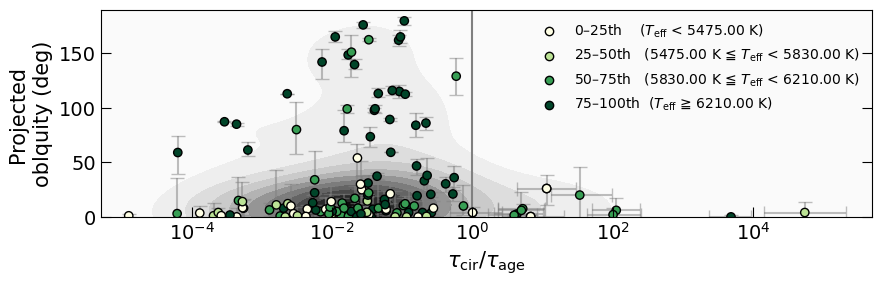

In [279]:
eccenlim = 0.1
tau_age_plot_lim = 5e5

y_vars = [
          "lambda",
         ] 

y_err_vars = [f"{var}err" for var in y_vars]

default_mask = hot_jupiters["pl_orbper"] > 0
default_mask &= ~hot_jupiters["tau_over_age"].isna()
default_mask &= hot_jupiters["tau_over_age"] < tau_age_plot_lim
default_mask &= hot_jupiters["tau_over_age"] > 0.0000
default_mask &=  ((hot_jupiters["pl_orbeccen"] <= eccenlim) | (hot_jupiters["tau_over_age"] <= 1))
    
masks = [
         default_mask & (hot_jupiters["lambda"]!=999),# & (hot_jupiters["pl_orbeccen"] < eccenlim),# & (hot_jupiters["pl_orbeccenlim"] == 1),
        ]

ylims = [
        (0,190),
        ]


data = plot_binned_subplots("tau_over_age", "tau_over_ageerr", y_vars, y_err_vars,masks,ylims,
                            show_hist=False,color_code=True,
                            color_code_param="st_teff",
                            scatter_color="dodgerblue",nearby_comp=False,
                            outpath="lambda_plot.pdf")